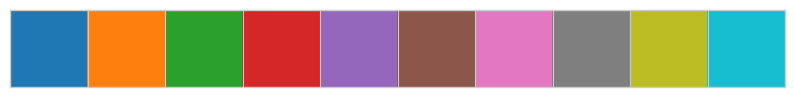

In [1]:
import sys
import shutil
import random
import re
import os
sys.path.append(os.path.realpath('../'))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image as pilImage
from IPython.display import Image, display

from src.utils.misc import get_project_root

color = sns.color_palette()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.palplot(color)

pd.set_option('display.max_colwidth', None)

%load_ext autoreload
%autoreload 2

In [2]:
LOG_DIR = get_project_root() / "data/parser"
DATA_DIR = get_project_root() / "data/raw_data"
print(LOG_DIR)
print(DATA_DIR)

/home/dmitrip/projects/kaliningradka/data/parser
/home/dmitrip/projects/kaliningradka/data/raw_data


# Data

## Getting links log

### Save CSV

In [5]:
# The line 1880 has unpredictable format containing ","
# Use the first three ones as a delimiter
def open_csv(file):
    data = []
    with open(file, 'r') as f:
        for line in f:
            parts = line.split(',', 3)
            parts[-1] = parts[-1].strip()
            data.append(parts)
    return data

# Convert the list of lists to a DataFrame
csv_file = open_csv(LOG_DIR / "image_links.txt")
df_links_1 = pd.DataFrame(csv_file, columns=['html_page_number', 'status', 'html_page_link', 'image_link'])
print(f"Number of records in image_links.txt file: {len(df_links_1)}")

csv_file = open_csv(LOG_DIR / "image_links_1.txt")
df_links_2 = pd.DataFrame(csv_file, columns=['html_page_number', 'status', 'html_page_link', 'image_link'])
print(f"Number of records in image_links_1.txt file: {len(df_links_2)}")

# Remove line 1880
df_links_1 = df_links_1[(df_links_1.index != 1880)]
# Remove status=3 records (all of them are in image_links_1.txt file)
df_links_1 = df_links_1[(df_links_1.status != '3')]

df_links = pd.concat([df_links_1, df_links_2], axis=0, ignore_index=True)
print(f"Number of aggregated records: {len(df_links)}")

output_file = DATA_DIR / "download_links_log.csv.gz"
df_links.to_csv(output_file, index=False, compression='gzip')

Number of records in image_links.txt file: 49704
Number of records in image_links_1.txt file: 53
Number of aggregated records: 49739


### Load CSV

In [4]:
df_links = pd.read_csv(LOG_DIR / "download_links_log.csv.gz", compression='gzip')
df_links = df_links[(df_links.status == 1)]
df_links = df_links.drop(columns=["html_page_number", "status"])
print(f"Number of image links: {len(df_links)}")
print(f"Number of unique image links: {df_links.image_link.nunique()}")

Number of image links: 49713
Number of unique image links: 48331


In [34]:
df_links.head()

,html_page_link,image_link
3,https://kaliningradka.kantiana.ru/archive/newspapers/4/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-1.JPG
4,https://kaliningradka.kantiana.ru/archive/newspapers/4/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-2.JPG
5,https://kaliningradka.kantiana.ru/archive/newspapers/4/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-3.JPG
6,https://kaliningradka.kantiana.ru/archive/newspapers/4/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-4.JPG
7,https://kaliningradka.kantiana.ru/archive/newspapers/5/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/2-13-12-46/2-12-46-1.JPG


### Display duplicates

In [35]:
df_links[df_links.duplicated('image_link', keep=False)].sort_values(by='image_link')

,html_page_link,image_link
3493,https://kaliningradka.kantiana.ru/archive/newspapers/910/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1951/1-1-1-51/1-1-51-1.jpg
3494,https://kaliningradka.kantiana.ru/archive/newspapers/911/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1951/1-1-1-51/1-1-51-1.jpg
46190,https://kaliningradka.kantiana.ru/archive/newspapers/11698/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1953/1-1-1-53/1-1-53-1.jpg
3496,https://kaliningradka.kantiana.ru/archive/newspapers/913/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1953/1-1-1-53/1-1-53-1.jpg
3497,https://kaliningradka.kantiana.ru/archive/newspapers/913/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1953/1-1-1-53/1-1-53-2.jpg
...,...,...
49665,https://kaliningradka.kantiana.ru/archive/newspapers/12597/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1971/269-16-11-17/269-11-71-2.jpg
49666,https://kaliningradka.kantiana.ru/archive/newspapers/12597/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1971/269-16-11-17/269-11-71-3.jpg
22617,https://kaliningradka.kantiana.ru/archive/newspapers/5778/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1971/269-16-11-17/269-11-71-3.jpg
22618,https://kaliningradka.kantiana.ru/archive/newspapers/5778/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1971/269-16-11-17/269-11-71-4.jpg


In [36]:
df_links[(df_links.image_link == "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1960/199-23-8-10/199-8-60-3.jpg")]

,html_page_link,image_link
10240,https://kaliningradka.kantiana.ru/archive/newspapers/2627/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1960/199-23-8-10/199-8-60-3.jpg
47111,https://kaliningradka.kantiana.ru/archive/newspapers/11930/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1960/199-23-8-10/199-8-60-3.jpg
49630,https://kaliningradka.kantiana.ru/archive/newspapers/12588/,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1960/199-23-8-10/199-8-60-3.jpg


## Download images log

In [3]:
df1 = pd.read_csv(LOG_DIR / "download_images_log.csv.gz", compression='gzip')
df2 = pd.read_csv(LOG_DIR / "download_images_response_error_log.csv.gz", compression='gzip')

df1 = df1[df1.status != 2] # These 42 files were downloaded in "download_images_response_error_log.csv.gz"
df = pd.concat([df1, df2], axis=0, ignore_index=True)
df = df[(df.index != 1877)] # Remove corrupted link
df = df.drop(columns=["line_number"])
df = df.rename(columns={'link': 'image_link'})
print(f"Total records (image links): {len(df)}")
print(f"Number of unique image links: {df.image_link.nunique()}")

Total records (image links): 49713
Number of unique image links: 48331


In [25]:
df.head()

,date,number,page,status,image_link,filename,extension
0,1946-12-09,1.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-1.JPG,1946-12-09_001_01.jpg,jpg
1,1946-12-09,1.0,2.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-2.JPG,1946-12-09_001_02.jpg,jpg
2,1946-12-09,1.0,3.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-3.JPG,1946-12-09_001_03.jpg,jpg
3,1946-12-09,1.0,4.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-4.JPG,1946-12-09_001_04.jpg,jpg
4,1946-12-13,2.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/2-13-12-46/2-12-46-1.JPG,1946-12-13_002_01.jpg,jpg


### Drop duplicates

In [4]:
df = df.drop_duplicates(subset=['status', 'image_link'])
print(f"Number of unique image links: {len(df)}")

Number of unique image links: 48331


# Data Quality Check

## Check for any missing data or null values

In [5]:
print(df.isnull().sum())

date          7
number        7
page          7
status        0
image_link    0
filename      7
extension     7
dtype: int64


In [8]:
# All nulls having status = 3 and downloaded manually
# http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/102-1-5-65/4.jpg - 1965-05-01_102_04.jpg
# http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/108-9-5-65/108-5-6504.jpg - 1965-05-09_108_04.jpg
# http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1986/169-24-7-86/169-7-86.jpg - 1986-07-24_169_01.jpg
# Last four files are rescanned duplicates

df[df.status != 1]

,date,number,page,status,image_link,filename,extension
14854,NaN,NaN,NaN,3,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/102-1-5-65/4.jpg,NaN,NaN
14874,NaN,NaN,NaN,3,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/108-9-5-65/108-5-6504.jpg,NaN,NaN
39553,NaN,NaN,NaN,3,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1986/169-24-7-86/169-7-86.jpg,NaN,NaN
49664,NaN,NaN,NaN,3,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1972/289-12-12-72(2)/289-12-72-1.jpg,NaN,NaN
49665,NaN,NaN,NaN,3,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1972/289-12-12-72(2)/289-12-72-2.jpg,NaN,NaN
49666,NaN,NaN,NaN,3,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1972/289-12-12-72(2)/289-12-72-3.jpg,NaN,NaN
49667,NaN,NaN,NaN,3,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1972/289-12-12-72(2)/289-12-72-4.jpg,NaN,NaN


In [5]:
# Fix manually downloaded images
df.loc[14854, ['date', 'number', 'page', 'status', 'filename', 'extension']] = [
    '1965-05-01', 102, 4, 1, '1965-05-01_102_04.jpg', 'jpg']
df.loc[14874, ['date', 'number', 'page', 'status', 'filename', 'extension']] = [
    '1965-05-09', 108, 4, 1, '1965-05-09_108_04.jpg', 'jpg']
df.loc[39553, ['date', 'number', 'page', 'status', 'filename', 'extension']] = [
    '1986-07-24', 169, 1, 1, '1986-07-24_169_01.jpg', 'jpg']

# Remove rescanned duplicates
index_list = [49664, 49665, 49666, 49667]
df = df.drop(index_list)

print(f"Total records: {len(df)}")

Total records: 48327


In [10]:
# Check 14854
df[df.image_link=="http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/102-1-5-65/4.jpg"]

,date,number,page,status,image_link,filename,extension
14854,1965-05-01,102.0,4.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/102-1-5-65/4.jpg,1965-05-01_102_04.jpg,jpg


## Сompare the list of files in the folder with the list of files in the dataframe

In [ ]:
# There are 48315 files in folder and 48327 files in the table

In [19]:
def compare_files():
    df_filenames = df['filename'].tolist()

    # Get list of filenames in the directory
    folder_filenames = os.listdir(DATA_DIR)  

    # Convert both lists to sets for easier comparison
    df_filenames_set = set(df_filenames)
    folder_filenames_set = set(folder_filenames)

    # Find files in the dataframe but not in the folder
    missing_in_folder = df_filenames_set - folder_filenames_set
    print(f"Files in dataframe but missing in folder: {len(missing_in_folder)}")

    # Find files in the folder but not in the dataframe
    missing_in_df = folder_filenames_set - df_filenames_set
    print(f"Files in folder but missing in dataframe: {len(missing_in_df)}")
    
compare_files()    

Files in dataframe but missing in folder: 0
Files in folder but missing in dataframe: 0


## File name duplicates

To remove: <br>
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-1.jpg
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-2.jpg
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-3.jpg
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-4.jpg

http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/226-2-10-79/236-10-79-1.jpg
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/226-2-10-79/236-10-79-2.jpg
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/226-2-10-79/236-10-79-3.jpg
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/226-2-10-79/236-10-79-4.jpg

http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/227-3-10-79/237-10-79-1.jpg
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/227-3-10-79/237-10-79-2.jpg
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/227-3-10-79/237-10-79-3.jpg
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/227-3-10-79/237-10-79-4.jpg

http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/54-6-3-65/64-3-65-2.jpg

Manually download:
http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/54-6-3-65/64-3-65-2.jpg <br>	
new name = 1965-03-18_064_02.jpg <br>
old_name = 1965-03-06_054_02.jpg <br>

http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/54-6-3-65/54-3-65-2.jpg <br>	
new name = 1965-03-06_054_02.jpg <br>
old_name = 1965-03-06_054_02.jpg <br>	

In [14]:
df[df.duplicated('filename', keep=False)].sort_values(by='filename')

,date,number,page,status,image_link,filename,extension
3043,1950-02-01,23.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-1.jpg,1950-02-01_023_01.jpg,jpg
47537,1950-02-01,23.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-50/23-2-50-1.jpg,1950-02-01_023_01.jpg,jpg
3044,1950-02-01,23.0,2.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-2.jpg,1950-02-01_023_02.jpg,jpg
47538,1950-02-01,23.0,2.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-50/23-2-50-2.jpg,1950-02-01_023_02.jpg,jpg
3045,1950-02-01,23.0,3.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-3.jpg,1950-02-01_023_03.jpg,jpg
47539,1950-02-01,23.0,3.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-50/23-2-50-3.jpg,1950-02-01_023_03.jpg,jpg
47540,1950-02-01,23.0,4.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-50/23-2-50-4.jpg,1950-02-01_023_04.jpg,jpg
3046,1950-02-01,23.0,4.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-4.jpg,1950-02-01_023_04.jpg,jpg
15771,1965-03-06,54.0,2.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/54-6-3-65/64-3-65-2.jpg,1965-03-06_054_02.jpg,jpg
15770,1965-03-06,54.0,2.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/54-6-3-65/54-3-65-2.jpg,1965-03-06_054_02.jpg,jpg


In [6]:
links_to_remove = [
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-1.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-2.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-3.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/23-1-2-51/23-2-50-4.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/226-2-10-79/236-10-79-1.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/226-2-10-79/236-10-79-2.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/226-2-10-79/236-10-79-3.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/226-2-10-79/236-10-79-4.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/227-3-10-79/237-10-79-1.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/227-3-10-79/237-10-79-2.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/227-3-10-79/237-10-79-3.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/227-3-10-79/237-10-79-4.jpg",
    "http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/54-6-3-65/64-3-65-2.jpg",
]
df = df[~df['image_link'].isin(links_to_remove)]

## Corrupted file names

- Move files to another folder using list
- Rename files (dict)
- Copy them to raw_data folder
- Fix table (date, number, page, filename, extension)

### Extensions

In [25]:
correct_ext = ["jpg", "png"]
df_ext = df[~df.extension.isin(correct_ext)]
print(f"Number of files having incorrect extensions: {len(df_ext)}")

Number of files having incorrect extensions: 80


In [30]:
pd.set_option('display.max_rows', None)
df_ext.sort_values(by="filename")

,date,number,page,status,image_link,filename,extension
1904,1949-01-02,2.0,49.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1949/2-2-1-49/2-2-1-49-1.jpg,1949-01-02_002_49.1,1
1905,1949-01-02,2.0,49.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1949/2-2-1-49/2-2-1-49-2.jpg,1949-01-02_002_49.2,2
1906,1949-01-02,2.0,49.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1949/2-2-1-49/2-2-1-49-3.jpg,1949-01-02_002_49.3,3
1907,1949-01-02,2.0,49.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1949/2-2-1-49/2-2-1-49-4.jpg,1949-01-02_002_49.4,4
2209,1949-01-07,4.0,49.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1949/4-7-1-49/4-7-1-49-1.jpg,1949-01-07_004_49.1,1
2210,1949-01-07,4.0,49.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1949/4-7-1-49/4-7-1-49-2.jpg,1949-01-07_004_49.2,2
2211,1949-01-07,4.0,49.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1949/4-7-1-49/4-7-1-49-3.jpg,1949-01-07_004_49.3,3
2212,1949-01-07,4.0,49.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1949/4-7-1-49/4-7-1-49-4.jpg,1949-01-07_004_49.4,4
6519,1956-11-25,234.0,56.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1956/234-25-11-56/234-25-11-56-1.jpg,1956-11-25_234_56.1,1
6520,1956-11-25,234.0,56.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1956/234-25-11-56/234-25-11-56-2.jpg,1956-11-25_234_56.2,2


In [7]:
file_matching = {
    "1949-01-02_002_49.1": "1949-01-04_002_01.jpg",
    "1949-01-02_002_49.2": "1949-01-04_002_02.jpg",
    "1949-01-02_002_49.3": "1949-01-04_002_03.jpg",
    "1949-01-02_002_49.4": "1949-01-04_002_04.jpg",    
    "1949-01-07_004_49.1": "1949-01-07_004_01.jpg", 
    "1949-01-07_004_49.2": "1949-01-07_004_02.jpg", 
    "1949-01-07_004_49.3": "1949-01-07_004_03.jpg", 
    "1949-01-07_004_49.4": "1949-01-07_004_04.jpg", 
    "1956-11-25_234_56.1": "1956-11-25_234_01.jpg",
    "1956-11-25_234_56.2": "1956-11-25_234_02.jpg",
    "1956-11-25_234_56.3": "1956-11-25_234_03.jpg",
    "1964-07-23_172_64.1": "1964-07-23_172_01.jpg",
    "1964-09-06_210_64.1": "1964-09-06_210_01.jpg",
    "1964-09-06_210_64.2": "1964-09-06_210_02.jpg",
    "1964-09-06_210_64.3": "1964-09-06_210_03.jpg",
    "1964-09-06_210_64.4": "1964-09-06_210_04.jpg",    
    "1964-09-08_211_64.1": "1964-09-08_211_01.jpg",
    "1964-09-08_211_64.2": "1964-09-08_211_02.jpg",
    "1964-09-08_211_64.3": "1964-09-08_211_03.jpg",    
    "1964-10-01_231_64.1": "1964-10-01_231_01.jpg",
    "1964-10-01_231_64.2": "1964-10-01_231_02.jpg",
    "1964-10-01_231_64.3": "1964-10-01_231_03.jpg",
    "1964-10-01_231_64.4": "1964-10-01_231_04.jpg",    
    "1964-10-31_257_64.1": "1964-10-31_257_01.jpg",
    "1964-10-31_257_64.2": "1964-10-31_257_02.jpg",
    "1964-10-31_257_64.3": "1964-10-31_257_03.jpg",
    "1964-10-31_257_64.4": "1964-10-31_257_04.jpg",    
    "1964-11-01_258_64.1": "1964-11-01_258_01.jpg",
    "1964-11-01_258_64.2": "1964-11-01_258_02.jpg",
    "1964-11-01_258_64.3": "1964-11-01_258_03.jpg",
    "1964-11-01_258_64.4": "1964-11-01_258_04.jpg",    
    "1964-11-03_259_64.1": "1964-11-03_259_01.jpg",
    "1964-11-03_259_64.2": "1964-11-03_259_02.jpg",
    "1964-11-03_259_64.3": "1964-11-03_259_03.jpg",
    "1964-11-03_259_64.4": "1964-11-03_259_04.jpg",    
    "1964-11-04_260_64.1": "1964-11-04_260_01.jpg",
    "1964-11-04_260_64.2": "1964-11-04_260_02.jpg",
    "1964-11-04_260_64.3": "1964-11-04_260_03.jpg",
    "1964-11-04_260_64.4": "1964-11-04_260_04.jpg",
    "1964-11-05_261_64.1": "1964-11-05_261_01.jpg",
    "1964-11-05_261_64.2": "1964-11-05_261_02.jpg",
    "1964-11-05_261_64.3": "1964-11-05_261_03.jpg",
    "1964-11-05_261_64.4": "1964-11-05_261_04.jpg", 
    "1964-11-06_262_64.1": "1964-11-06_262_01.jpg",
    "1964-11-06_262_64.2": "1964-11-06_262_02.jpg",
    "1964-11-06_262_64.3": "1964-11-06_262_03.jpg",
    "1964-11-06_262_64.4": "1964-11-06_262_04.jpg",  
    "1964-11-07_263_64.1": "1964-11-07_263_01.jpg",
    "1964-11-07_263_64.2": "1964-11-07_263_02.jpg",
    "1964-11-07_263_64.3": "1964-11-07_263_03.jpg",
    "1964-11-07_263_64.4": "1964-11-07_263_04.jpg",
    "1964-11-10_264_64.1": "1964-11-10_264_01.jpg",
    "1964-11-10_264_64.2": "1964-11-10_264_02.jpg",
    "1964-11-10_264_64.3": "1964-11-10_264_03.jpg",
    "1964-11-10_264_64.4": "1964-11-10_264_04.jpg",      
    "1964-12-31_037_64.1": "1964-12-31_307_01.jpg",
    "1964-12-31_037_64.2": "1964-12-31_307_02.jpg",
    "1964-12-31_037_64.3": "1964-12-31_307_03.jpg",
    "1964-12-31_037_64.4": "1964-12-31_307_04.jpg",    
    "1967-07-05_155_67.1": "1967-07-05_155_01.jpg",
    "1967-07-05_155_67.2": "1967-07-05_155_02.jpg",
    "1967-07-05_155_67.3": "1967-07-05_155_03.jpg",
    "1967-07-05_155_67.4": "1967-07-05_155_04.jpg",
    "1967-07-06_156_67.1": "1967-07-06_156_01.jpg",
    "1967-07-06_156_67.2": "1967-07-06_156_02.jpg",
    "1967-07-06_156_67.3": "1967-07-06_156_03.jpg",
    "1967-07-06_156_67.4": "1967-07-06_156_04.jpg",     
    "1967-08-12_188_1967.1": "1967-08-12_188_01.jpg",
    "1967-08-12_188_1967.2": "1967-08-12_188_02.jpg",
    "1967-08-12_188_1967.3": "1967-08-12_188_03.jpg",
    "1967-08-12_188_1967.4": "1967-08-12_188_04.jpg",    
    "1967-08-13_189_1967.1": "1967-08-13_189_01.jpg",
    "1967-08-13_189_1967.2": "1967-08-13_189_02.jpg",
    "1967-08-13_189_1967.3": "1967-08-13_189_03.jpg",
    "1967-08-13_189_1967.4": "1967-08-13_189_04.jpg",   
    "1967-08-15_190_1967.1": "1967-08-15_190_01.jpg",
    "1967-08-15_190_1967.2": "1967-08-15_190_02.jpg",
    "1967-08-15_190_1967.3": "1967-08-15_190_03.jpg",
    "1967-08-15_190_1967.4": "1967-08-15_190_04.jpg",     
    "1986-07-02_152_86.1": "1986-07-02_152_01.jpg",
}

In [8]:
dest_dir = get_project_root() / "data/corrupted_file_names"

moved_files_counter = 0

# Move each file
for file_name in file_matching.keys():
    # create source file path
    source_file = DATA_DIR / file_name
    
    # check if source file exists
    if os.path.isfile(source_file):
        # create destination file path
        dest_file = dest_dir / file_name
        
        # move file from source to destination
        try:
            shutil.move(source_file, dest_file)
            moved_files_counter += 1
        except FileNotFoundError as e:
            print(f"Failed to move {source_file} to {dest_file}. Error: {e}")            
    else:
        print(f"File {source_file} does not exist.")
        
print(f"Number of moved files: {moved_files_counter}")        

File /home/dmitrip/projects/kaliningradka/data/raw_data/1949-01-02_002_49.1 does not exist.
File /home/dmitrip/projects/kaliningradka/data/raw_data/1949-01-02_002_49.2 does not exist.
File /home/dmitrip/projects/kaliningradka/data/raw_data/1949-01-02_002_49.3 does not exist.
File /home/dmitrip/projects/kaliningradka/data/raw_data/1949-01-02_002_49.4 does not exist.
File /home/dmitrip/projects/kaliningradka/data/raw_data/1949-01-07_004_49.1 does not exist.
File /home/dmitrip/projects/kaliningradka/data/raw_data/1949-01-07_004_49.2 does not exist.
File /home/dmitrip/projects/kaliningradka/data/raw_data/1949-01-07_004_49.3 does not exist.
File /home/dmitrip/projects/kaliningradka/data/raw_data/1949-01-07_004_49.4 does not exist.
File /home/dmitrip/projects/kaliningradka/data/raw_data/1956-11-25_234_56.1 does not exist.
File /home/dmitrip/projects/kaliningradka/data/raw_data/1956-11-25_234_56.2 does not exist.
File /home/dmitrip/projects/kaliningradka/data/raw_data/1956-11-25_234_56.3 does

In [38]:
# Rename each file
for current_name, new_name in file_matching.items():
    # Create current file path
    current_file = dest_dir / current_name
    
    # Check if current file exists
    if os.path.isfile(current_file):
        # Create new file path
        new_file = dest_dir / new_name
        
        # Rename the file
        os.rename(current_file, new_file)
    else:
        print(f"File {current_file} does not exist.")

In [27]:
def update_dataframe(df, file_matching):
    # Create a copy of the dataframe to avoid changing the original one
    df = df.copy()
    
    # Identify the rows where the filename exists in the file_matching dictionary
    mask = df['filename'].isin(file_matching.keys())
    
    # Rename filename values using the file_matching dictionary
    df.loc[mask, 'filename'] = df.loc[mask, 'filename'].map(file_matching)
    
    # Parse the new filenames and update the date, number, page, and extension columns
    df.loc[mask, 'date'] = pd.to_datetime(df.loc[mask, 'filename'].str.slice(0,10), format='%Y-%m-%d')
    df.loc[mask, 'number'] = df.loc[mask, 'filename'].str.slice(11,14).astype(int)
    df.loc[mask, 'page'] = df.loc[mask, 'filename'].str.slice(15,17).astype(int)
    df.loc[mask, 'extension'] = df.loc[mask, 'filename'].str.slice(-3)
    
    return df

df = update_dataframe(df, file_matching)

### File name length

In [51]:
# Identify the filenames whose length is not 21
incorrect_length_filenames = df[df['filename'].apply(len) != 21]

# Print the number of such filenames
print("Number of filenames with incorrect length:", incorrect_length_filenames.shape[0])

incorrect_length_filenames

Number of filenames with incorrect length: 4


,date,number,page,status,image_link,filename,extension
49644,1969-111-19,270.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1969/270-19-111-69/270-11-69-1.jpg,1969-111-19_270_01.jpg,jpg
49645,1969-111-19,270.0,2.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1969/270-19-111-69/270-11-69-2.jpg,1969-111-19_270_02.jpg,jpg
49646,1969-111-19,270.0,3.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1969/270-19-111-69/270-11-69-3.jpg,1969-111-19_270_03.jpg,jpg
49647,1969-111-19,270.0,4.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1969/270-19-111-69/270-11-69-4.jpg,1969-111-19_270_04.jpg,jpg


In [10]:
file_matching = {
    "1969-111-19_270_01.jpg": "1969-11-19_270_01.jpg",
    "1969-111-19_270_02.jpg": "1969-11-19_270_02.jpg",
    "1969-111-19_270_03.jpg": "1969-11-19_270_03.jpg",
    "1969-111-19_270_04.jpg": "1969-11-19_270_04.jpg",    
}

In [28]:
def move_files(file_matching):
    dest_dir = get_project_root() / "data/corrupted_file_names"

    moved_files_counter = 0

    # Move each file
    for file_name in file_matching.keys():
        # create source file path
        source_file = DATA_DIR / file_name

        # check if source file exists
        if os.path.isfile(source_file):
            # create destination file path
            dest_file = dest_dir / file_name

            # move file from source to destination
            try:
                shutil.move(source_file, dest_file)
                moved_files_counter += 1
            except FileNotFoundError as e:
                print(f"Failed to move {source_file} to {dest_file}. Error: {e}")            
        else:
            print(f"File {source_file} does not exist.")
        
    print(f"Number of moved files: {moved_files_counter}") 

In [ ]:
move_files(file_matching)

In [29]:
def rename_files(file_matching):
    dest_dir = get_project_root() / "data/corrupted_file_names"
    
    # Rename each file
    for current_name, new_name in file_matching.items():
        # Create current file path
        current_file = dest_dir / current_name

        # Check if current file exists
        if os.path.isfile(current_file):
            # Create new file path
            new_file = dest_dir / new_name

            # Rename the file
            os.rename(current_file, new_file)
        else:
            print(f"File {current_file} does not exist.")       

In [ ]:
rename_files()  

In [11]:
df = update_dataframe(df, file_matching)

### File format (pages from 1 to 9)

In [66]:
# Create the regex for the filename format
filename_regex = r"^(19[4-6][0-9]|197[0-9]|198[0-9]|199[0-1])-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])_([0-3][0-9][0-9])_(0[1-9])\.(jpg|png)$"

# Identify the filenames that don't match the regex
incorrect_format_filenames = df[~df['filename'].str.match(filename_regex)]

# Print the number of such filenames
print("Number of filenames with incorrect format:", incorrect_format_filenames.shape[0])

incorrect_format_filenames

Number of filenames with incorrect format: 17


,date,number,page,status,image_link,filename,extension
478,1947-07-04,77.0,11.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1947/77-4-7-47/77-7-47-11.jpg,1947-07-04_077_11.jpg,jpg
10381,1960-10-01,233.0,60.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1960/233-1-10-60/233-10-60-60.jpg,1960-10-01_233_60.jpg,jpg
15736,1965-02-25,46.0,24.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1965/46-25-2-65/46-2-65-24.jpg,1965-02-25_046_24.jpg,jpg
22987,1971-03-31,75.0,10.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1971/75-31-3-71/75-3-71-10.jpg,1971-03-31_075_10.jpg,jpg
30053,1977-02-20,43.0,77.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1977/43-20-2-77/43-20-2-77.jpg,1977-02-20_043_77.jpg,jpg
31340,1978-03-31,76.0,11.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1978/76-31-3-78/75-3-78-11.jpg,1978-03-31_076_11.jpg,jpg
31341,1978-03-31,76.0,12.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1978/76-31-3-78/75-3-78-12.jpg,1978-03-31_076_12.jpg,jpg
31342,1978-03-31,76.0,13.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1978/76-31-3-78/75-3-78-13.jpg,1978-03-31_076_13.jpg,jpg
31343,1978-03-31,76.0,14.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1978/76-31-3-78/75-3-78-14.jpg,1978-03-31_076_14.jpg,jpg
49047,1952-12-54,252.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1952/252-54-12-52/252-12-52-1.png,1952-12-54_252_01.png,png


In [12]:
# 1965-02-25_046_24.jpg - remove file and record
# 1947-07-04_077_11.jpg - remove file and record
# 1971-03-31_075_10.jpg - correct
file_matching = {
    "1960-10-01_233_60.jpg": "1960-10-01_233_04.jpg",
    "1977-02-20_043_77.jpg": "1977-02-20_043_04.jpg",
    "1978-03-31_076_11.jpg": "1978-03-31_075_01.jpg",
    "1978-03-31_076_12.jpg": "1978-03-31_075_02.jpg",
    "1978-03-31_076_13.jpg": "1978-03-31_075_03.jpg",
    "1978-03-31_076_14.jpg": "1978-03-31_075_04.jpg",
    "1952-12-54_252_01.png": "1952-12-24_252_01.png",
    "1952-12-54_252_02.png": "1952-12-24_252_02.png",
    "1952-12-54_252_03.png": "1952-12-24_252_03.png",
    "1952-12-54_252_04.png": "1952-12-24_252_04.png",
    "1954-00-05_091_01.jpg": "1954-05-05_091_01.jpg",
    "1954-00-05_091_02.jpg": "1954-05-05_091_02.jpg", 
    "1954-00-05_091_03.jpg": "1954-05-05_091_03.jpg", 
    "1954-00-05_091_04.jpg": "1954-05-05_091_04.jpg",     
}

In [13]:
df = df[df.index != 15736]
df = df[df.index != 478]

In [18]:
move_files(file_matching)

Number of moved files: 15


In [22]:
rename_files() 

In [14]:
df = update_dataframe(df, file_matching)

### Year

In [29]:
# Extract the year from the filenames
filename_years = df['filename'].str.slice(0,4).astype(int)

# Identify the filenames where the year is not between 1946 and 1991
incorrect_year_filenames = df[(filename_years < 1946) | (filename_years > 1991)]

# Print the number of such filenames
print("Number of filenames with incorrect year:", incorrect_year_filenames.shape[0])

# Print the list of such filenames
incorrect_year_filenames

Number of filenames with incorrect year: 0


,date,number,page,status,image_link,filename,extension


### Month

In [30]:
# Extract the month from the filenames
filename_months = df['filename'].str.slice(5,7).astype(int)

# Identify the filenames where the month is not between 01 and 12
incorrect_month_filenames = df[(filename_months < 1) | (filename_months > 12)]

# Print the number of such filenames
print("Number of filenames with incorrect month:", incorrect_month_filenames.shape[0])

# Print the list of such filenames
incorrect_month_filenames

Number of filenames with incorrect month: 0


,date,number,page,status,image_link,filename,extension


### Day

In [31]:
# Extract the day from the filenames
filename_days = df['filename'].str.slice(8,10).astype(int)

# Identify the filenames where the day is not between 01 and 31
incorrect_day_filenames = df[(filename_days < 1) | (filename_days > 31)]

# Print the number of such filenames
print("Number of filenames with incorrect day:", incorrect_day_filenames.shape[0])

incorrect_day_filenames

Number of filenames with incorrect day: 0


,date,number,page,status,image_link,filename,extension


### Number

In [32]:
# Extract the issue number from the filenames
filename_numbers = df['filename'].str.slice(11,14).astype(int)

# Identify the filenames where the issue number is not between 001 and 350
incorrect_number_filenames = df[(filename_numbers < 1) | (filename_numbers > 350)]

# Print the number of such filenames
print("Number of filenames with incorrect issue number:", incorrect_number_filenames.shape[0])

incorrect_number_filenames

Number of filenames with incorrect issue number: 0


,date,number,page,status,image_link,filename,extension


### Page

In [39]:
def check_pages(min_page, max_page):
    # Extract the page number from the filenames
    filename_pages = df['filename'].str.slice(15,17).astype(int)

    # Identify the filenames where the page number is not between 01 and 09
    incorrect_page_filenames = df[(filename_pages < min_page) | (filename_pages > max_page)]

    # Print the number of such filenames
    print("Number of filenames with incorrect page number:", incorrect_page_filenames.shape[0])

    return incorrect_page_filenames

def check_page_range(min_page, max_page):
    # Extract the page number from the filenames
    filename_pages = df['filename'].str.slice(15,17).astype(int)

    # Identify the filenames where the page number is not between 01 and 09
    incorrect_page_filenames = df[(filename_pages >= min_page) & (filename_pages < max_page)]

    # Print the number of such filenames
    print("Number of filenames with incorrect page number:", incorrect_page_filenames.shape[0])

    return incorrect_page_filenames

In [38]:
incorrect_page_filenames = check_pages(min_page=1, max_page=9)
incorrect_page_filenames

Number of filenames with incorrect page number: 1


,date,number,page,status,image_link,filename,extension
22987,1971-03-31,75.0,10.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1971/75-31-3-71/75-3-71-10.jpg,1971-03-31_075_10.jpg,jpg


#### 9 pages

In [41]:
check_page_range(min_page=9, max_page=10)

Number of filenames with incorrect page number: 1


,date,number,page,status,image_link,filename,extension
22986,1971-03-31,75.0,9.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1971/75-31-3-71/75-3-71-9.jpg,1971-03-31_075_09.jpg,jpg


#### 8 pages

In [40]:
incorrect_page_filenames = check_page_range(min_page=8, max_page=9)
incorrect_page_filenames

Number of filenames with incorrect page number: 20


,date,number,page,status,image_link,filename,extension
293,1947-03-01,25.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1947/25-1-3-47/25-3-47-8.JPG,1947-03-01_025_08.jpg,jpg
301,1947-03-04,26.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1947/26-4-3-47/26-3-47-8.JPG,1947-03-04_026_08.jpg,jpg
2389,1949-01-12,8.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1949/8-12-1-49/8-1-49-8.jpg,1949-01-12_008_08.jpg,jpg
3026,1950-11-14,225.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/225-14-11-50/225-11-50-8.jpg,1950-11-14_225_08.jpg,jpg
4447,1954-01-29,20.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1954/20-29-1-54/20-1-54-8.jpg,1954-01-29_020_08.jpg,jpg
6656,1956-02-16,34.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1956/34-16-2-56/34-2-56-8.jpg,1956-02-16_034_08.jpg,jpg
7470,1957-11-07,220.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1957/220-7-11-57/220-11-57-8.jpg,1957-11-07_220_08.jpg,jpg
11590,1961-10-18,247.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1961/247-18-10-61/247-18-61-8.jpg,1961-10-18_247_08.jpg,jpg
11598,1961-10-19,248.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1961/248-19-10-61/248-10-61-8.jpg,1961-10-19_248_08.jpg,jpg
12583,1962-11-20,272.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1962/272-20-11-62/272-11-62-8.jpg,1962-11-20_272_08.jpg,jpg


In [ ]:
# 1967-07-01_152_05.jpg - 1967-07-02_153_01.jpg - duplicates remove
# 1967-07-01_152_06.jpg - 1967-07-02_153_02.jpg - duplicates remove
# 1967-07-01_152_07.jpg - 1967-07-02_153_03.jpg - duplicates remove
# 1967-07-01_152_08.jpg - 1967-07-02_153_04.jpg - duplicates remove
file_matching = {
    "1949-01-12_008_08.jpg": "1949-01-12_008_04.jpg",
    "1950-11-14_225_08.jpg": "1950-11-14_225_04.jpg", 
}

In [15]:
files_to_delete = [
    "1967-07-01_152_05.jpg",
    "1967-07-01_152_06.jpg",
    "1967-07-01_152_07.jpg",
    "1967-07-01_152_08.jpg",
]
df[df.filename.isin(files_to_delete)]

,date,number,page,status,image_link,filename,extension
17400,1967-07-01,152.0,5.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1967/152-1-7-67/152-7-67-5.jpg,1967-07-01_152_05.jpg,jpg
17401,1967-07-01,152.0,6.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1967/152-1-7-67/152-7-67-6.jpg,1967-07-01_152_06.jpg,jpg
17402,1967-07-01,152.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1967/152-1-7-67/152-7-67-7.jpg,1967-07-01_152_07.jpg,jpg
17403,1967-07-01,152.0,8.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1967/152-1-7-67/152-7-67-8.jpg,1967-07-01_152_08.jpg,jpg


In [16]:
df = df[~df.filename.isin(files_to_delete)]

#### 7 pages

In [44]:
# Stop on 3025
incorrect_page_filenames = check_page_range(min_page=7, max_page=8)
incorrect_page_filenames

Number of filenames with incorrect page number: 22


,date,number,page,status,image_link,filename,extension
292,1947-03-01,25.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1947/25-1-3-47/25-3-47-7.JPG,1947-03-01_025_07.jpg,jpg
300,1947-03-04,26.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1947/26-4-3-47/26-3-47-7.JPG,1947-03-04_026_07.jpg,jpg
2388,1949-01-12,8.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1949/8-12-1-49/8-1-49-7.jpg,1949-01-12_008_07.jpg,jpg
3025,1950-11-14,225.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1950/225-14-11-50/225-11-50-7.jpg,1950-11-14_225_07.jpg,jpg
4446,1954-01-29,20.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1954/20-29-1-54/20-1-54-7.jpg,1954-01-29_020_07.jpg,jpg
6655,1956-02-16,34.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1956/34-16-2-56/34-2-56-7.jpg,1956-02-16_034_07.jpg,jpg
7469,1957-11-07,220.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1957/220-7-11-57/220-11-57-7.jpg,1957-11-07_220_07.jpg,jpg
11589,1961-10-18,247.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1961/247-18-10-61/247-18-61-7.jpg,1961-10-18_247_07.jpg,jpg
11597,1961-10-19,248.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1961/248-19-10-61/248-10-61-7.jpg,1961-10-19_248_07.jpg,jpg
12582,1962-11-20,272.0,7.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1962/272-20-11-62/272-11-62-7.jpg,1962-11-20_272_07.jpg,jpg


#### Rename pages

In [45]:
# 8 pages
file_matching_8 = {
    "1949-01-12_008_08.jpg": "1949-01-12_008_04.jpg",
    "1950-11-14_225_08.jpg": "1950-11-14_225_04.jpg", 
}

In [46]:
move_files(file_matching_8)

Number of moved files: 2


In [49]:
rename_files(file_matching_8)  

In [50]:
df = update_dataframe(df, file_matching_8)

### Day is out of range for month (1969-04-31)

In [23]:
from datetime import datetime

def check_date(row):
    try:
        datetime(int(row['filename'][0:4]), int(row['filename'][5:7]), int(row['filename'][8:10]))
        return True
    except ValueError:
        return False

# Apply the check_date function to each row
df['date_valid'] = df.apply(check_date, axis=1)

# Identify the rows where the date is not valid
incorrect_date_rows = df[~df['date_valid']]

# Print the number of such rows
print("Number of rows where date in filename is out of range:", incorrect_date_rows.shape[0])

# Print the details of such rows
print("Rows where date in filename is out of range:", incorrect_date_rows)

# Drop the 'date_valid' column as it's no longer needed
df = df.drop('date_valid', axis=1)

Number of rows where date in filename is out of range: 4
Rows where date in filename is out of range:              date  number  page  status  \
49640  1969-04-31   125.0   1.0       1   
49641  1969-04-31   125.0   2.0       1   
49642  1969-04-31   125.0   3.0       1   
49643  1969-04-31   125.0   4.0       1   

                                                                                        image_link  \
49640  http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1969/125-31-4-69/125-4-69-1.jpg   
49641  http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1969/125-31-4-69/125-4-69-2.jpg   
49642  http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1969/125-31-4-69/125-4-69-3.jpg   
49643  http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1969/125-31-4-69/125-4-69-4.jpg   

                    filename extension  date_valid  
49640  1969-04-31_125_01.jpg       jpg       False  
49641  1969-04-31_125_02.jpg       jpg       False  
49642  1969-

In [25]:
file_matching = {
    "1969-04-31_125_01.jpg": "1969-05-31_125_01.jpg",
    "1969-04-31_125_02.jpg": "1969-05-31_125_02.jpg",
    "1969-04-31_125_03.jpg": "1969-05-31_125_03.jpg",
    "1969-04-31_125_04.jpg": "1969-05-31_125_04.jpg",
}

In [30]:
move_files(file_matching)

Number of moved files: 4


In [31]:
rename_files(file_matching)

In [32]:
df = update_dataframe(df, file_matching)

## Final check

In [33]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,number,page,status,image_link,filename,extension
0,1946-12-09,1.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-1.JPG,1946-12-09_001_01.jpg,jpg
1,1946-12-09,1.0,2.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-2.JPG,1946-12-09_001_02.jpg,jpg
2,1946-12-09,1.0,3.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-3.JPG,1946-12-09_001_03.jpg,jpg
3,1946-12-09,1.0,4.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-4.JPG,1946-12-09_001_04.jpg,jpg
4,1946-12-13,2.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/2-13-12-46/2-12-46-1.JPG,1946-12-13_002_01.jpg,jpg


In [34]:
print(f"Total records (image links): {len(df)}")
print(f"Number of unique image links: {df.image_link.nunique()}")
print(f"Number of unique images: {df.image_link.nunique()}")

Total records (image links): 48308
Number of unique image links: 48308
Number of unique images: 48308


In [35]:
print(df.isnull().sum())

date          0
number        0
page          0
status        0
image_link    0
filename      0
extension     0
dtype: int64


In [36]:
compare_files()

Files in dataframe but missing in folder: 0
Files in folder but missing in dataframe: 0


In [37]:
def compare_year():
    # Extract the year from the 'date' column
    date_years = df['date'].dt.year

    # Extract the year from the filenames
    filename_years = df['filename'].str.slice(0,4).astype(int)

    # Identify the rows where the year from the filename is not equal to the year from the 'date' column
    incorrect_year_rows = df[date_years != filename_years]

    print("Number of rows where year in filename does not match year column:", incorrect_year_rows.shape[0])
    print("Rows where year in filename does not match year column:", incorrect_year_rows)
    
compare_year()    

Number of rows where year in filename does not match year column: 0
Rows where year in filename does not match year column: Empty DataFrame
Columns: [date, number, page, status, image_link, filename, extension]
Index: []


In [38]:
def compare_month():
    date_months = df['date'].dt.month
    filename_months = df['filename'].str.slice(5,7).astype(int)
    incorrect_month_rows = df[date_months != filename_months]
    print("Number of rows where month in filename does not match month column:", incorrect_month_rows.shape[0])
    print("Rows where month in filename does not match month column:", incorrect_month_rows)
    
compare_month() 

Number of rows where month in filename does not match month column: 0
Rows where month in filename does not match month column: Empty DataFrame
Columns: [date, number, page, status, image_link, filename, extension]
Index: []


In [41]:
def compare_days():
    date_days = df['date'].dt.day
    filename_days = df['filename'].str.slice(8,10).astype(int)
    incorrect_day_rows = df[date_days != filename_days]
    print("Number of rows where month in filename does not match month column:", incorrect_day_rows.shape[0])
    print("Rows where month in filename does not match month column:", incorrect_day_rows)
    
compare_days() 

Number of rows where month in filename does not match month column: 0
Rows where month in filename does not match month column: Empty DataFrame
Columns: [date, number, page, status, image_link, filename, extension]
Index: []


In [44]:
def compare_pages():
    page_numbers = df['page']
    filename_pages = df['filename'].str.slice(15,17).astype(int)
    incorrect_page_rows = df[page_numbers != filename_pages]

    print("Number of rows where page in filename does not match 'page' column:", incorrect_page_rows.shape[0])
    print("Rows where page in filename does not match 'page' column:", incorrect_page_rows)
    
compare_pages() 

Number of rows where page in filename does not match 'page' column: 0
Rows where page in filename does not match 'page' column: Empty DataFrame
Columns: [date, number, page, status, image_link, filename, extension]
Index: []


In [45]:
def compare_numbers():
    page_numbers = df['number']
    filename_pages = df['filename'].str.slice(11,14).astype(int)
    incorrect_page_rows = df[page_numbers != filename_pages]

    print("Number of rows where page in filename does not match 'page' column:", incorrect_page_rows.shape[0])
    print("Rows where page in filename does not match 'page' column:", incorrect_page_rows)
    
compare_numbers() 

Number of rows where page in filename does not match 'page' column: 0
Rows where page in filename does not match 'page' column: Empty DataFrame
Columns: [date, number, page, status, image_link, filename, extension]
Index: []


In [47]:
def compare_ext():
    page_numbers = df['extension']
    filename_pages = df['filename'].str.slice(-3)
    incorrect_page_rows = df[page_numbers != filename_pages]

    print("Number of rows where page in filename does not match 'page' column:", incorrect_page_rows.shape[0])
    print("Rows where page in filename does not match 'page' column:", incorrect_page_rows)
    
compare_ext() 

Number of rows where page in filename does not match 'page' column: 0
Rows where page in filename does not match 'page' column: Empty DataFrame
Columns: [date, number, page, status, image_link, filename, extension]
Index: []


### Save update table

In [48]:
output_file = get_project_root() / "data/parser/download_images_log_updated.csv.gz"
df.to_csv(output_file, index=False, compression='gzip')

# Descriptive Analysis

In [31]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [32]:
df = pd.read_csv(LOG_DIR / "download_images_log_updated.csv.gz", compression='gzip')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

df.head()

,date,number,page,status,image_link,filename,extension,year,month,day
0,1946-12-09,1.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-1.JPG,1946-12-09_001_01.jpg,jpg,1946,12,9
1,1946-12-09,1.0,2.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-2.JPG,1946-12-09_001_02.jpg,jpg,1946,12,9
2,1946-12-09,1.0,3.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-3.JPG,1946-12-09_001_03.jpg,jpg,1946,12,9
3,1946-12-09,1.0,4.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/1-9-12-46/1-12-46-4.JPG,1946-12-09_001_04.jpg,jpg,1946,12,9
4,1946-12-13,2.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1946/2-13-12-46/2-12-46-1.JPG,1946-12-13_002_01.jpg,jpg,1946,12,13


In [ ]:
def plot_count(
      df_plot: pd.DataFrame,
      title: str,
      x_label: str,
      y_label: str,
      x_col: str,
      y_col: str,
      fig_x_size: int = 12,
      fig_y_size: int = 8,
      y_scale=None,
      xticks_rotation: int = 0,
      xticks_font: int = 11,
):
    plt.figure(figsize=(fig_x_size, fig_y_size))
    g = sns.barplot(x=x_col, y=y_col, data=df_plot, color=color[0])
    if y_scale is not None:
        if y_scale == 'M':
            ylabels = ['{:,.0f}'.format(y) + ' M' for y in g.get_yticks()/1000000]
        elif y_scale == 'K':
            ylabels = ['{:,.0f}'.format(y) + ' K' for y in g.get_yticks()/1000]    
        g.set_yticklabels(ylabels)
    plt.ylabel(y_label, fontsize=14, labelpad=20)
    plt.xlabel(x_label, fontsize=14, labelpad=20)
    plt.xticks(fontsize=xticks_font, rotation = xticks_rotation)
    plt.yticks(fontsize=11)
    if x_col in missing_dict:
        title = title + f' ({missing_dict[x_col]} records missed)'
    plt.title(title, fontsize=16)
    plt.grid(True, axis='y', alpha=0.5)
    plt.show()

## Distribution of file extensions

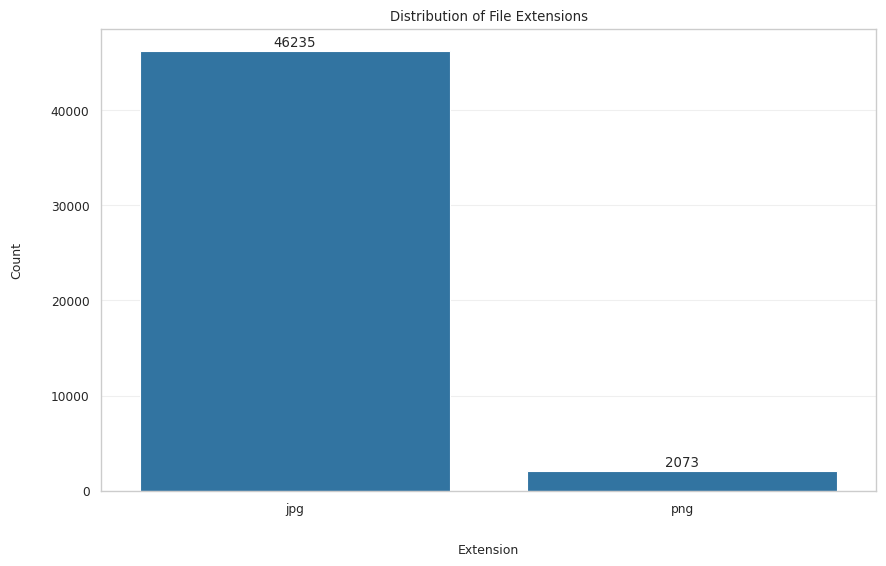

In [24]:
plt.figure(figsize=(10, 6))  # Set plot size
ax = sns.countplot(x='extension', data=df, color=color[0])

# Add count annotations to the top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 500, '{}'.format(height), ha='center')

plt.ylabel("Count", fontsize=10, labelpad=20)
plt.xlabel("Extension", fontsize=10, labelpad=20)
plt.title('Distribution of File Extensions')     
plt.grid(True, axis='y', alpha=0.3)
plt.show()

## Distribution of newspaper issues over years

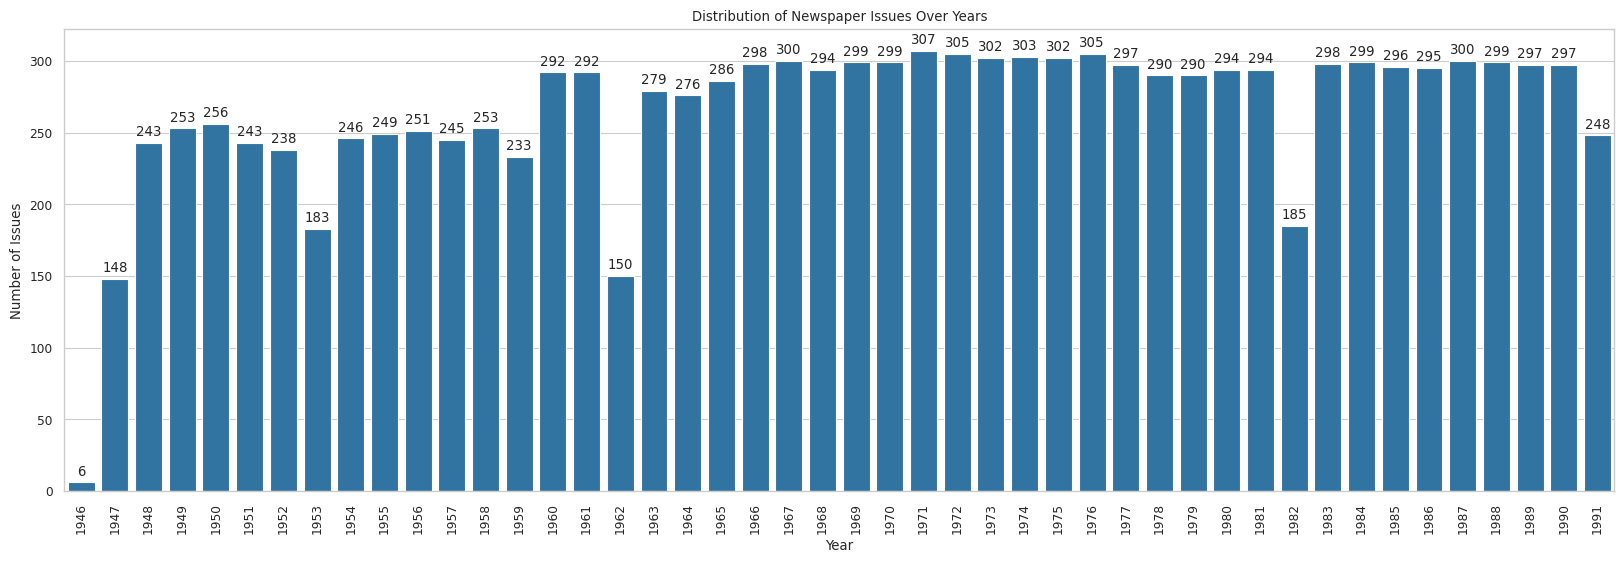

In [27]:
# Count unique issues per year
issues_per_year = df.groupby('year')['number'].nunique()

# Create a bar plot with seaborn
plt.figure(figsize=(20, 6))  # Set plot size
ax = sns.barplot(x=issues_per_year.index, y=issues_per_year.values, color=color[0])

# Add count annotations to the top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, '{}'.format(int(height)), ha='center')

plt.xticks(rotation=90)
plt.title('Distribution of Newspaper Issues Over Years')  # Add title
plt.xlabel('Year')
plt.ylabel('Number of Issues')

plt.show()

## Distribution of newspaper issues over months (less than 200)

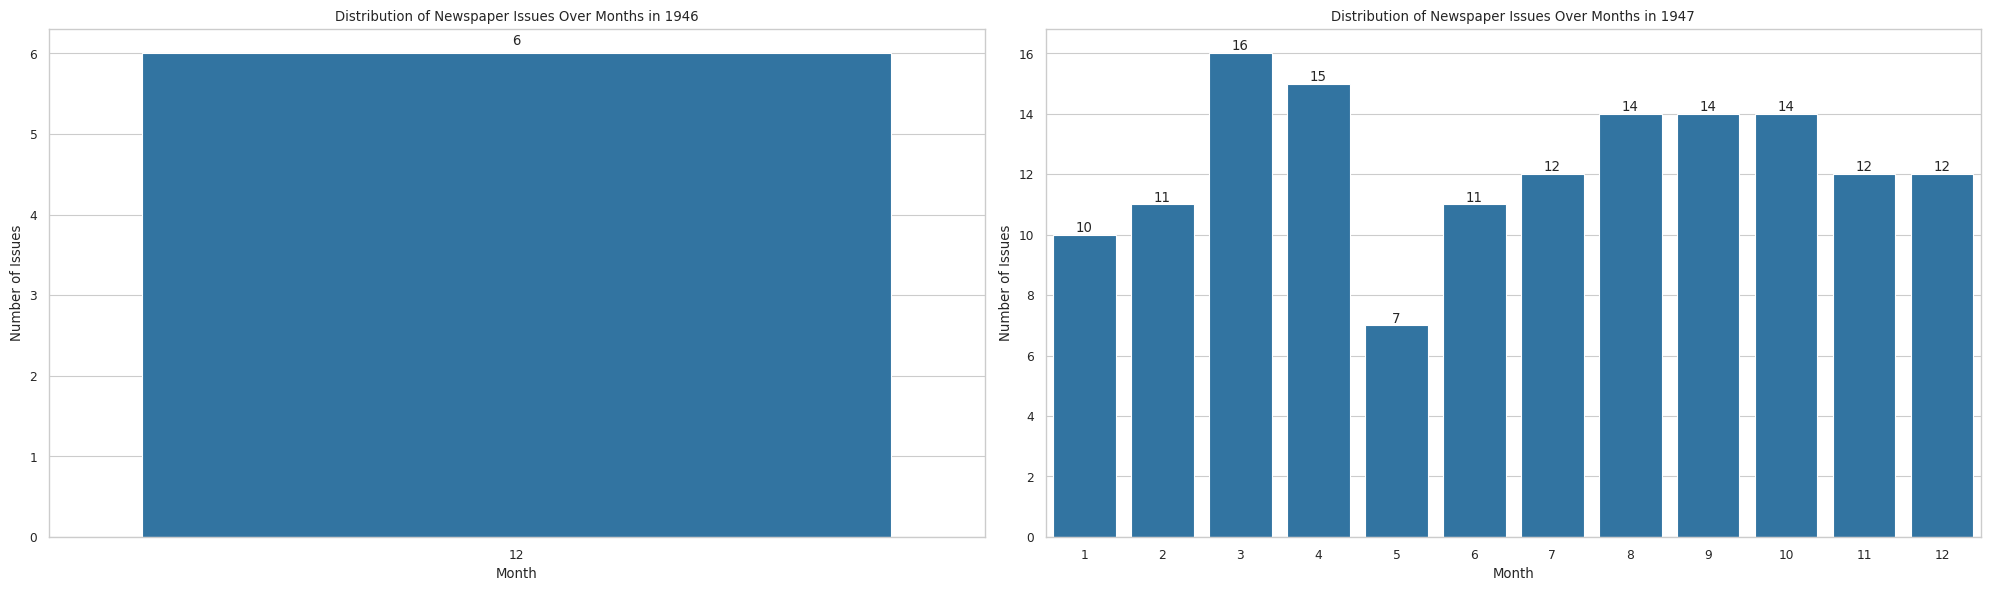

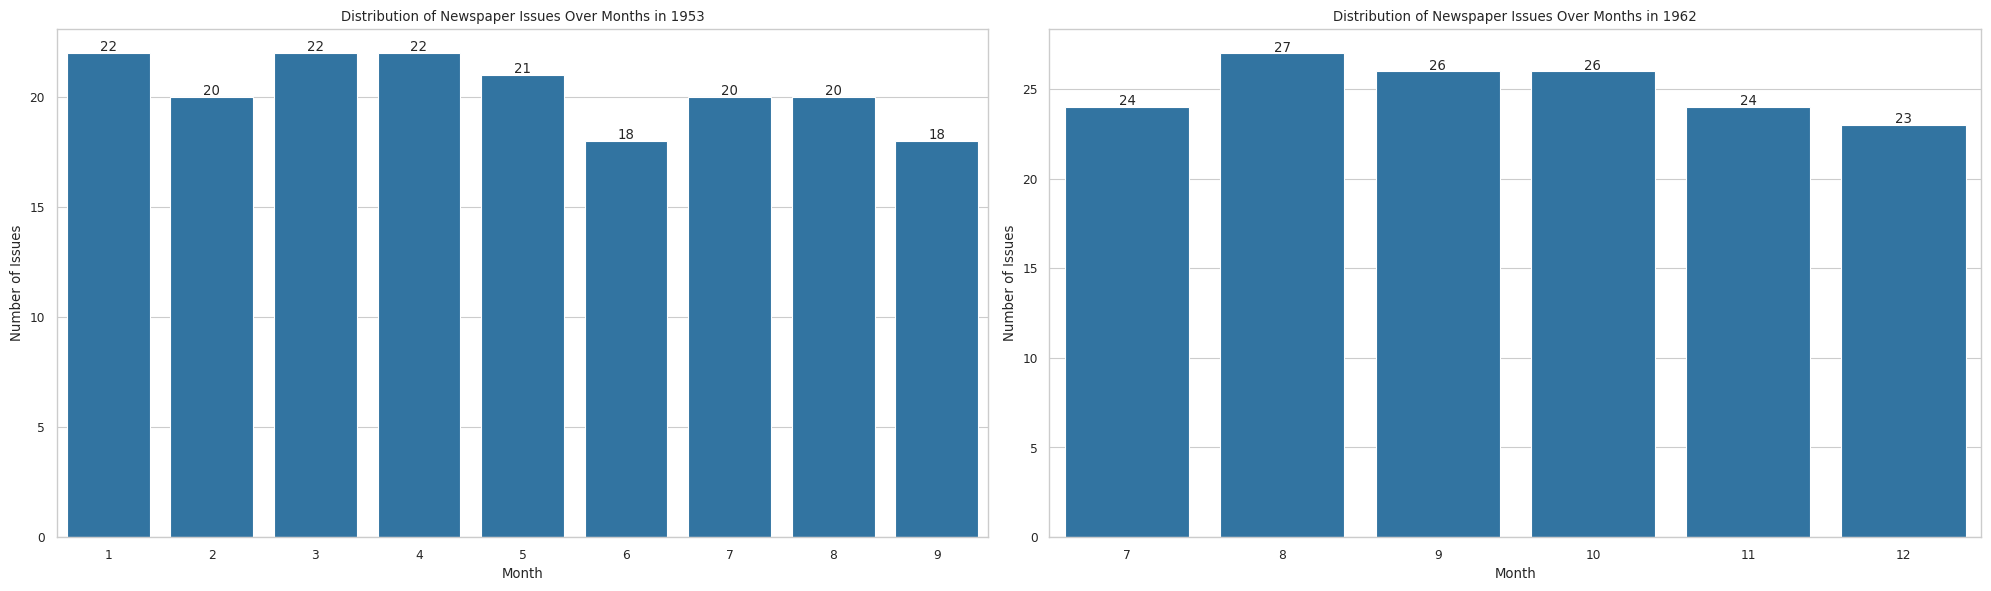

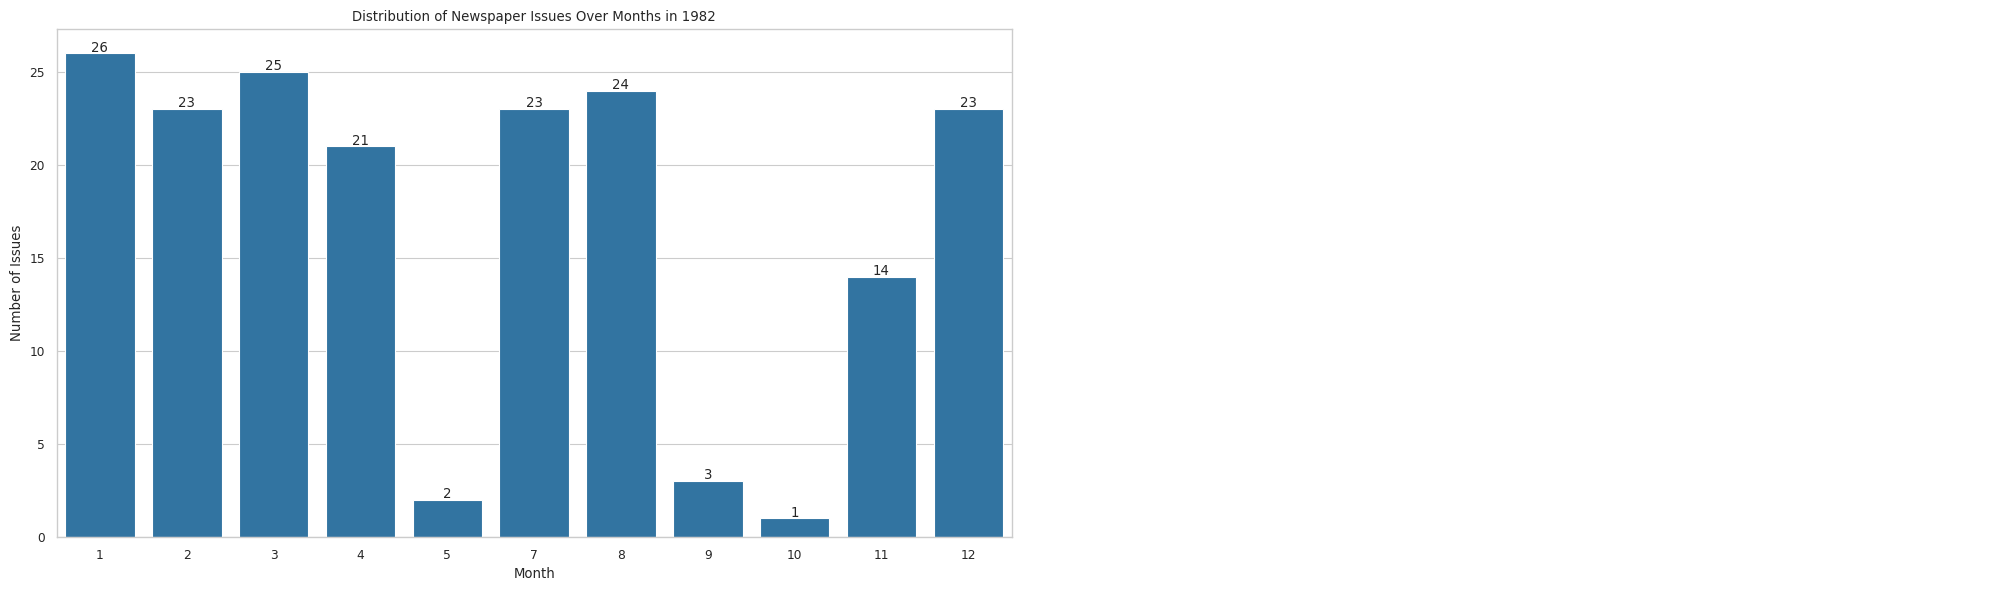

In [51]:
# Count unique issues per year
issues_per_year = df.groupby('year')['number'].nunique()

# Get years where number of issues is less than 200
years_less_than_200 = issues_per_year[issues_per_year < 200].index

# For each pair of years, plot the distribution of newspaper issues over months
for i in range(0, len(years_less_than_200), 2):
    plt.figure(figsize=(20, 6))  # Set plot size
    
    for j in range(2):
        ax = plt.subplot(1, 2, j + 1)
        
        if i + j < len(years_less_than_200):
            year = years_less_than_200[i + j]
            df_year = df[df['year'] == year]
            issues_per_month = df_year.groupby('month')['number'].nunique()
            
            sns.barplot(x=issues_per_month.index, y=issues_per_month.values, ax=ax, color=color[0])
            
            # Add count annotations to the top of each bar
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x() + p.get_width() / 2, height+0.1, '{}'.format(int(height)), ha='center')
            
            ax.set_title('Distribution of Newspaper Issues Over Months in {}'.format(year))  # Add title
            ax.set_xlabel('Month')
            ax.set_ylabel('Number of Issues')
        else:
            ax.axis('off')  # Hide subplot if there's no data for it

    plt.tight_layout()
    plt.show()

## Issues containing more than 4 pages

In [54]:
df_grouped = df.groupby(['date', 'number'])['page'].max().reset_index()

# Filter out the groups where the maximum page number is less than or equal to 4
df_filtered = df_grouped[df_grouped['page'] > 4]
print(f"Number of issues having more than 4 pages: {len(df_filtered)}")
df_filtered

Number of issues having more than 4 pages: 81


,date,number,page
27,1947-03-01,25.0,8.0
28,1947-03-04,26.0,8.0
54,1947-04-27,49.0,6.0
114,1947-09-27,115.0,6.0
402,1949-01-09,6.0,6.0
...,...,...,...
11650,1989-11-23,268.0,6.0
11831,1990-07-03,150.0,6.0
12188,1991-10-31,216.0,6.0
12197,1991-11-14,225.0,6.0


## Probable missed issues

In [61]:
import warnings
warnings.filterwarnings('ignore')

# For each year, get the maximum issue number
max_issues_per_year = df.groupby('year')['number'].max()

# Initialize an empty DataFrame to store the missing issues
missing_issues = pd.DataFrame(columns=['year', 'missing_issue'])

# For each year, identify the missing issues
for year, max_issue in max_issues_per_year.items():
    all_issues = set(range(1, int(max_issue) + 1))  # All possible issues for the year
    actual_issues = set(df[df['year'] == year]['number'].unique())  # Actual issues in the data
    missing = all_issues - actual_issues  # Missing issues
    
    for issue in missing:
        missing_issues = missing_issues.append({'year': year, 'missing_issue': issue}, ignore_index=True)

# Print the DataFrame of missing issues
missing_issues.sort_values(by=["year", "missing_issue"])

,year,missing_issue
1,1947,4
4,1947,12
5,1947,16
9,1947,56
3,1947,74
...,...,...
621,1991,229
628,1991,245
629,1991,246
619,1991,256


In [64]:
missing_issues[missing_issues.year==1947].sort_values(by=["year", "missing_issue"])

,year,missing_issue
1,1947,4
4,1947,12
5,1947,16
9,1947,56
3,1947,74
8,1947,86
11,1947,124
0,1947,128
2,1947,133
6,1947,147


## Probable missed pages

In [69]:
# For each 'date' and 'number', get the maximum page number
max_pages_per_issue = df.groupby(['date', 'number'])['page'].max()

# Initialize an empty DataFrame to store the missing pages
missing_pages = pd.DataFrame(columns=['date', 'issue_number', 'missing_page'])

# For each 'date' and 'number', identify the missing pages
for (date, number), max_page in max_pages_per_issue.iteritems():
    all_pages = set(range(1, int(max_page) + 1))  # All possible pages for the issue
    actual_pages = set(df[(df['date'] == date) & (df['number'] == number)]['page'].unique())  # Actual pages in the data
    missing = all_pages - actual_pages  # Missing pages
    
    for page in missing:
        missing_pages = missing_pages.append({'date': date, 'issue_number': number, 'missing_page': page}, ignore_index=True)

# Print the DataFrame of missing pages
missing_pages

,date,issue_number,missing_page
0,1947-09-25,114.0,1
1,1948-01-13,7.0,1
2,1948-01-16,9.0,1
3,1948-01-17,10.0,1
4,1948-03-19,57.0,1
...,...,...,...
453,1987-07-26,171.0,1
454,1990-02-13,37.0,1
455,1990-04-13,86.0,1
456,1990-05-02,102.0,2


In [70]:
df[df.date=="1990-05-02"]

,date,number,page,status,image_link,filename,extension,year,month,day
43999,1990-05-02,102.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1990/102-2-5-90/102-5-90-1.jpg,1990-05-02_102_01.jpg,jpg,1990,5,2
44000,1990-05-02,102.0,4.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1990/102-2-5-90/102-5-90-4.jpg,1990-05-02_102_04.jpg,jpg,1990,5,2


# File attributes

In [74]:
# Initialize new columns
df['filesize'] = np.nan
df['width_resolution'] = np.nan
df['height_resolution'] = np.nan

# Fetch the file attributes
for i, row in df.iterrows():
    filename = row['filename']
    filepath = DATA_DIR / filename
    
    # Filesize
    filesize = os.path.getsize(filepath)  # in bytes
    df.at[i, 'filesize'] = filesize
    
    # Image resolution
    with Image.open(filepath) as img:
        width, height = img.size
        df.at[i, 'width_resolution'] = width
        df.at[i, 'height_resolution'] = height

In [75]:
df[filesize]
print(df[['filesize', 'width_resolution', 'height_resolution']].describe())

           filesize  width_resolution  height_resolution
count  4.830800e+04           48308.0       48308.000000
mean   1.523030e+06            2000.0        2782.194212
std    1.892594e+06               0.0         127.816418
min    8.412700e+04            2000.0        1425.000000
25%    1.067974e+06            2000.0        2725.000000
50%    1.128376e+06            2000.0        2795.000000
75%    1.194899e+06            2000.0        2861.000000
max    1.659771e+07            2000.0        5289.000000


In [77]:
min_size = df.filesize.min()
df[df.filesize==min_size]

,date,number,page,status,image_link,filename,extension,year,month,day,filesize,width_resolution,height_resolution
5702,1955-01-07,4.0,4.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1955/4-7-1-55/4-1-55-4.jpg,1955-01-07_004_04.jpg,jpg,1955,1,7,84127.0,2000.0,2668.0
20105,1969-10-15,241.0,4.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1969/241-15-10-69/241-10-69-4.jpg,1969-10-15_241_04.jpg,jpg,1969,10,15,84127.0,2000.0,2671.0


In [78]:
max_size = df.filesize.max()
df[df.filesize==max_size]

,date,number,page,status,image_link,filename,extension,year,month,day,filesize,width_resolution,height_resolution
48078,1953-07-29,151.0,2.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1953/151-29-7-53/151-7-53-2.png,1953-07-29_151_02.png,png,1953,7,29,16597707.0,2000.0,5289.0


# Random image

In [4]:
output_file = LOG_DIR / "download_images_log_updated.csv.gz"
df = pd.read_csv(output_file, compression='gzip')
df.sample(5)

,date,number,page,status,image_link,filename,extension,year,month,day,filesize,width_resolution,height_resolution
16955,1966-03-03,52.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1966/52-3-3-66/52-3-66-1.jpg,1966-03-03_052_01.jpg,jpg,1966,3,3,1018453.0,2000.0,2805.0
13572,1963-02-20,43.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1963/43-20-2-63/43-2-63-1.jpg,1963-02-20_043_01.jpg,jpg,1963,2,20,1014183.0,2000.0,2640.0
19580,1969-04-28,122.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1969/122-28-4-69/122-4-69-1.jpg,1969-04-28_122_01.jpg,jpg,1969,4,28,1036314.0,2000.0,2526.0
13812,1964-05-12,110.0,1.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1964/110-12-5-64/110-5-64-1.jpg,1964-05-12_110_01.jpg,jpg,1964,5,12,1104368.0,2000.0,2813.0
31911,1979-09-11,209.0,3.0,1,http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1979/209-11-9-79/209-9-79-3.jpg,1979-09-11_209_03.jpg,jpg,1979,9,11,1202743.0,2000.0,2740.0


In [12]:
def get_random_image(year: int = None, month: int = None, page: int = None) -> str:
    # Filter dataframe based on given year and/or month
    if year and month:
        filtered_df = df[(df['year'] == year) & (df['month'] == month)]
    elif year:
        filtered_df = df[df['year'] == year]
    else:
        filtered_df = df
        
    if page:
        filtered_df = filtered_df[filtered_df['page'] == page]
    
    if filtered_df.empty:
        return "No such raws in the table."
    
    # Select a random row from the filtered dataframe
    random_row = filtered_df.sample()
    
    # Get the filename of the selected row
    filename = random_row['filename'].values[0]
    
    # Construct the full path of the file
    file_path = os.path.join(DATA_DIR, filename)
    
    # Check if the file exists
    if not os.path.isfile(file_path):
        return f"There is the filename {filename}, but file does not exist: {file_path}"
    
    print(f"Number of files satisfying the condition: {len(filtered_df)}")
    print(f'{filename}')
    link = random_row['image_link'].values[0]
    print(f'Link: {link}')  
    
    return file_path


def display_image(year: int = None, month: int = None, page: int = None):
    # Get a random image file path
    image_file = get_random_image(year, month, page)

    display(Image(image_file))
    return image_file


def display_scaled_image(image_file, new_height=1200):
    with pilImage.open(image_file) as img:
        width, height = img.size
        print(f'File Name: {image_file}')
        print(f'Original Height: {height}')     

        new_width = int(new_height * width / height)
        img = img.resize((new_width, new_height))
        display(img)

Number of files satisfying the condition: 147
1947-09-19_111_01.jpg
Link: http://kaliningradka.kantiana.ru/media/preview/%D0%9A%D0%9F/1947/111-19-9-47/111-9-47-1.jpg


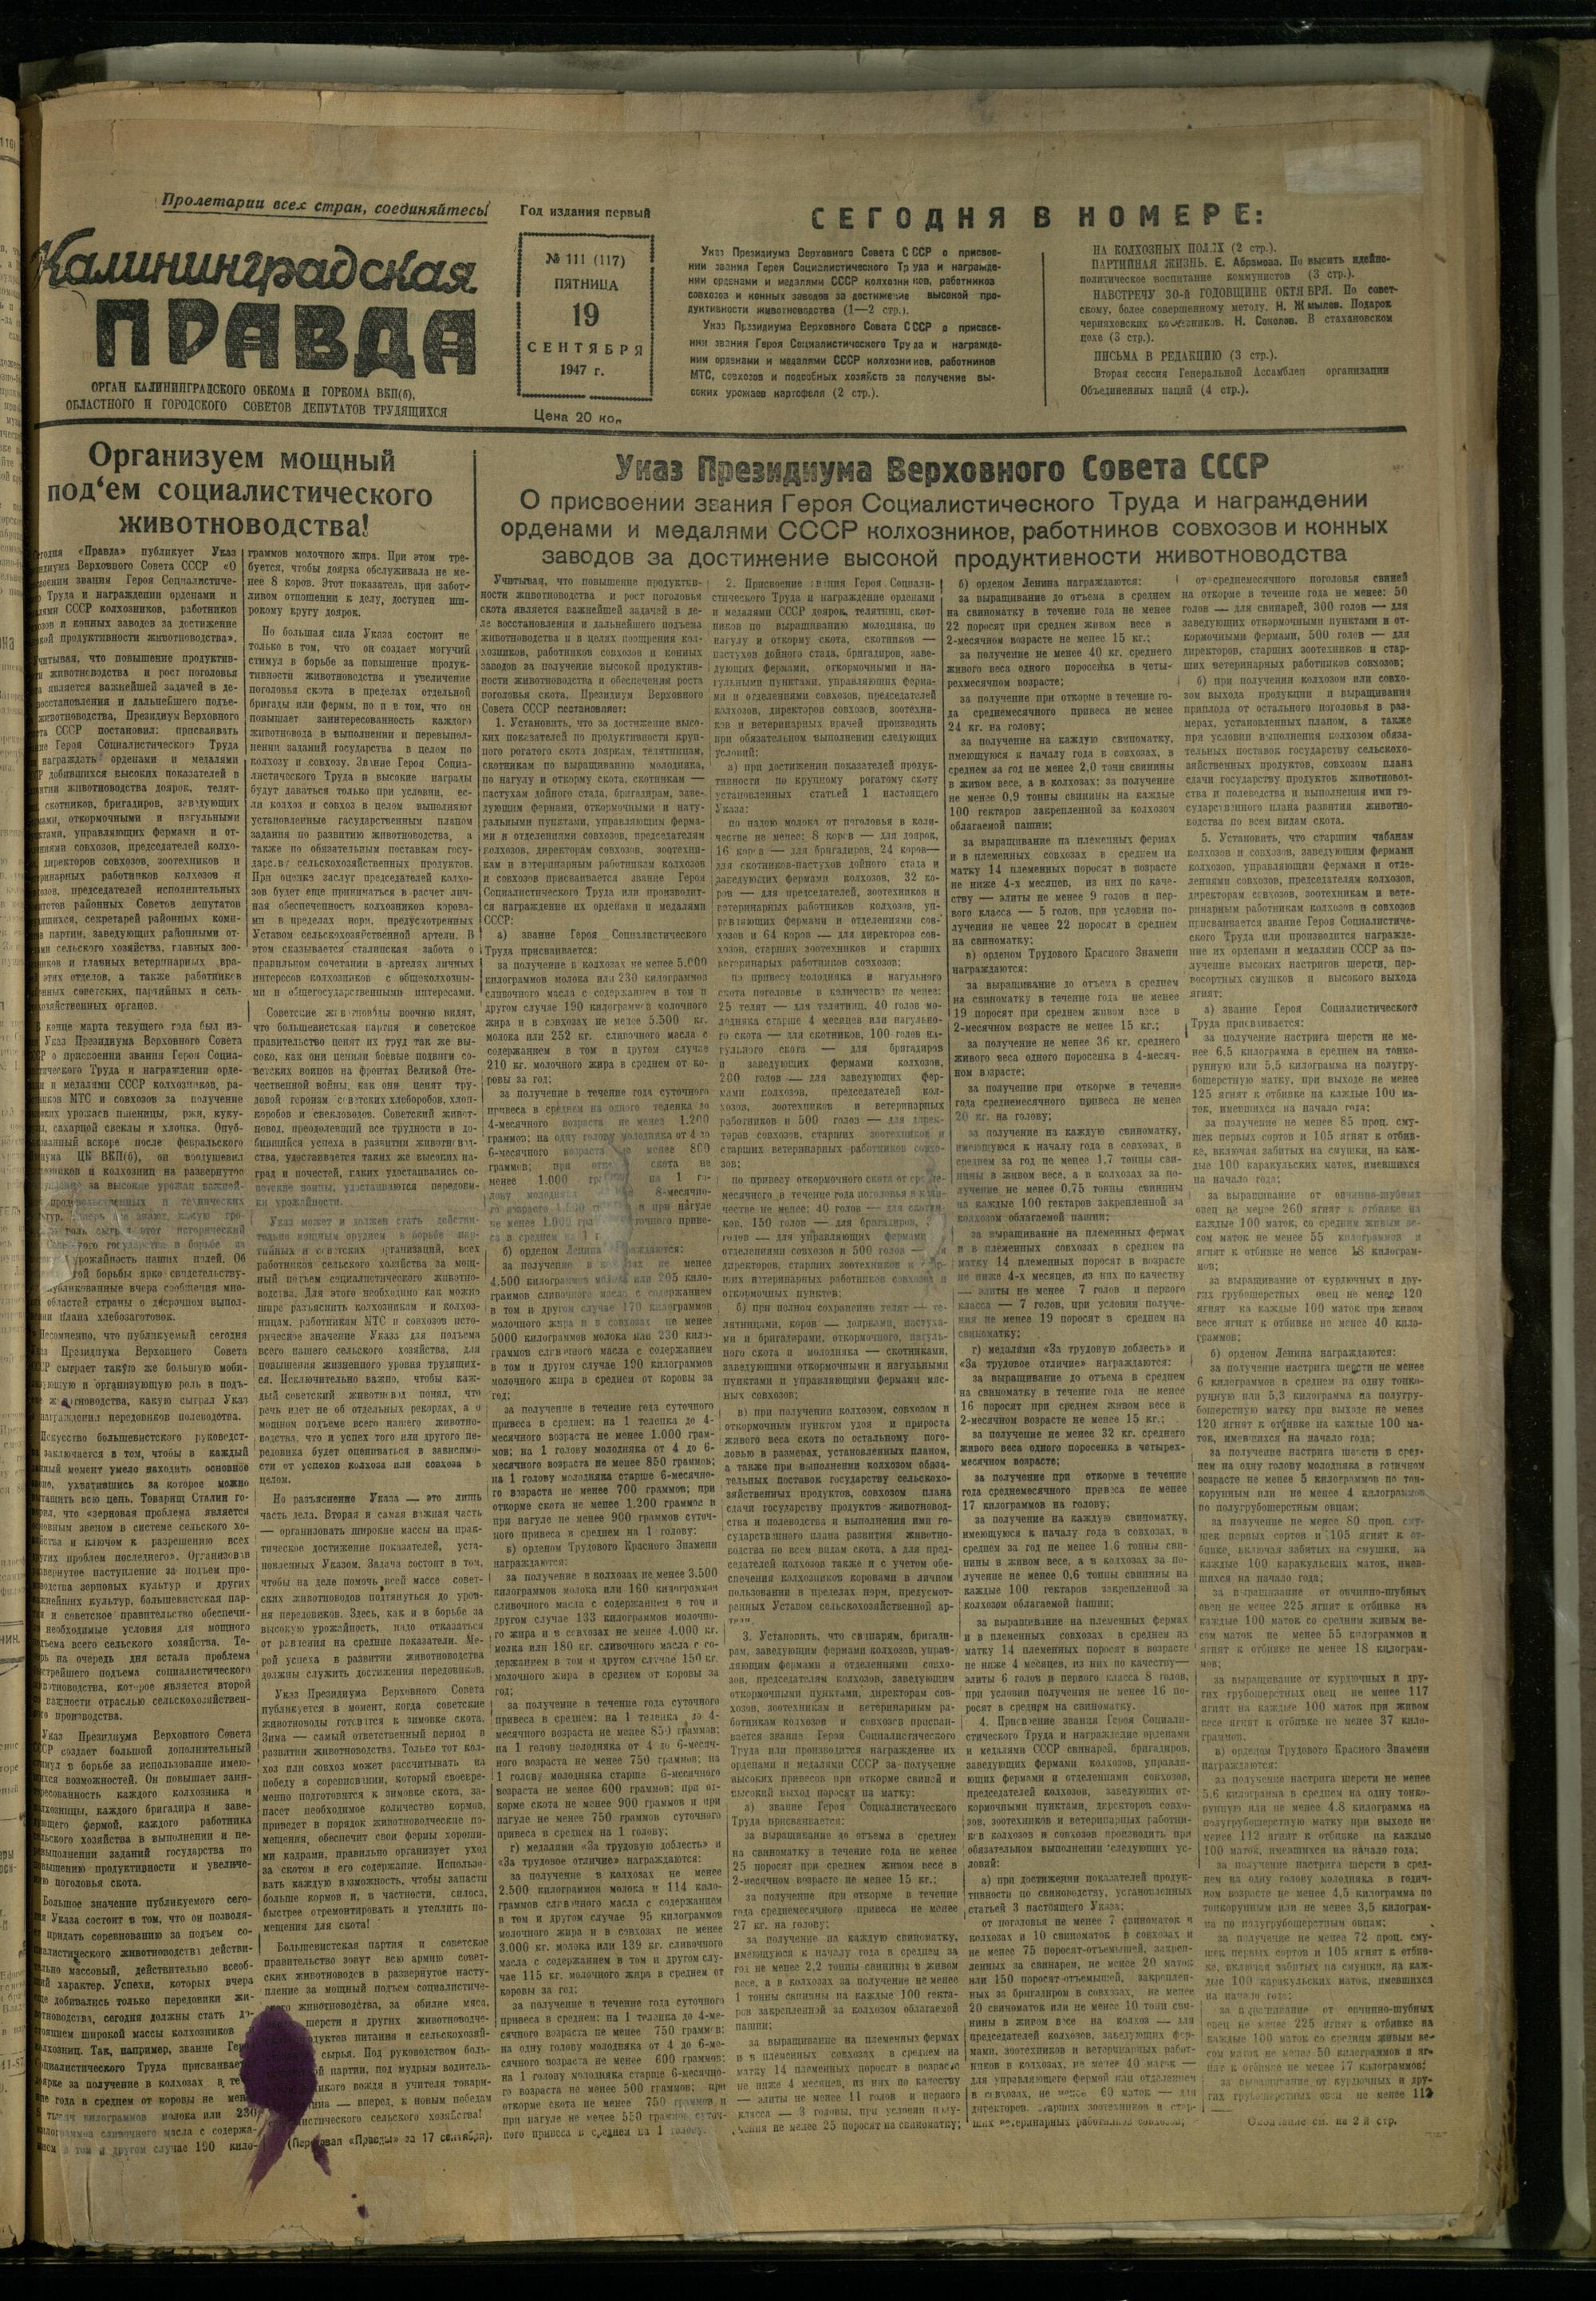

In [6]:
image_file = display_image(year=1947, month=None, page=1)

File Name: /home/dmitrip/projects/kaliningradka/data/raw_data/1947-09-19_111_01.jpg
Original Height: 2883


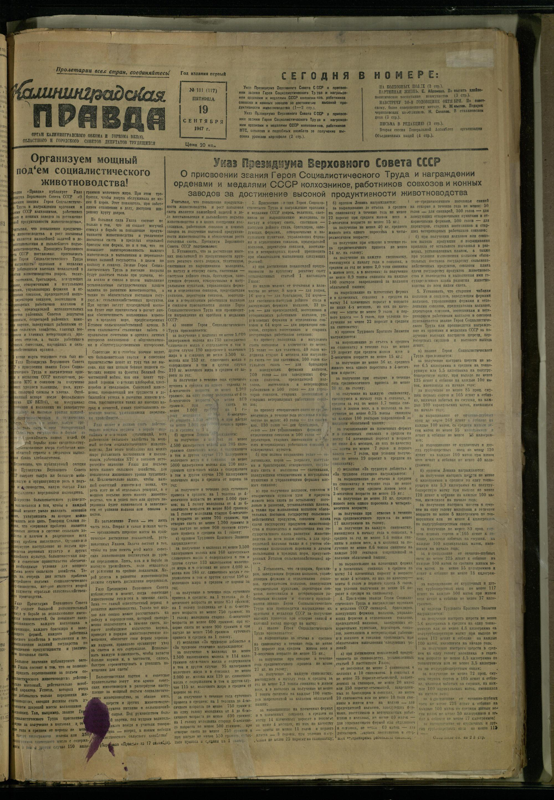

In [15]:
display_scaled_image(image_file, new_height=800)

# Draft